In [1]:
import torch
from Define_Model.ResNet import LocalResNet
from Define_Model.Loss.SoftmaxLoss import AdditiveMarginLinear

import numpy as np
import kaldi_io
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rc('font', family='Times New Roman')


In [2]:
model = LocalResNet(resnet_size=8, block_type='cbam', channels=[64, 128, 256],
                 input_len=300, inst_norm=False, input_dim=161, sr=16000, input_norm='Mean',
                 kernel_size=5, stride=2, padding=2, dropout_p=0.25, exp=False, filter_fix=False,
                 feat_dim=64, num_classes=1211, embedding_size=256, fast='None', time_dim=1, avg_size=4,
                 alpha=0, encoder_type='None', )

model.classifier = AdditiveMarginLinear(feat_dim=256, num_classes=1211)
ckp = torch.load('/home/yangwenhao/local/project/SpeakerVerification-pytorch/Data/checkpoint/LoResNet8/vox1/klsp_egs_baseline/arcsoft/None_cbam_em256_alpha0_dp25_wd5e4_dev_aug_com_var/checkpoint_40.pth')
model.load_state_dict(ckp['state_dict'])

# print(list(ckp['state_dict'][0].keys()))
all_layers = []
for name, m in model.named_modules():
    all_layers.append(name)
    
print(all_layers)

# module = model.layer4[0].bn2
# b = - (module.running_mean * module.weight / torch.sqrt(module.running_var + module.eps)) + module.bias
# b.data.shape

/home/yangwenhao/local/project/SpeakerVerification-pytorch/Define_Model/Loss/SoftmaxLoss.py:152: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(self.W, gain=1)


['', 'relu', 'inst_layer', 'conv1', 'bn1', 'layer1', 'layer1.0', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.CBAM_layer', 'layer1.0.CBAM_layer.cov_t', 'layer1.0.CBAM_layer.avg_t', 'layer1.0.CBAM_layer.cov_f', 'layer1.0.CBAM_layer.avg_f', 'layer1.0.CBAM_layer.activation', 'conv2', 'bn2', 'layer2', 'layer2.0', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.CBAM_layer', 'layer2.0.CBAM_layer.cov_t', 'layer2.0.CBAM_layer.avg_t', 'layer2.0.CBAM_layer.cov_f', 'layer2.0.CBAM_layer.avg_f', 'layer2.0.CBAM_layer.activation', 'conv3', 'bn3', 'layer3', 'layer3.0', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.CBAM_layer', 'layer3.0.CBAM_layer.cov_t', 'layer3.0.CBAM_layer.avg_t', 'layer3.0.CBAM_layer.cov_f', 'layer3.0.CBAM_layer.avg_f', 'layer3.0.CBAM_layer.activation', 'dropout', 'avgpool', 'fc', 'fc.0', 'fc.1', 'classifier']


/home/yangwenhao/anaconda3/envs/py37/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [3]:
out_feature_grads = []
in_feature_grads = []

def extract_layer_bias(module):
    # extract bias of each layer

    # for batchnorm, the overall "bias" is different
    # from batchnorm bias parameter.
    # Let m -> running mean, s -> running std
    # Let w -> BN weights, b -> BN bias
    # Then, ((x - m)/s)*w + b = x*w/s + (- m*w/s + b)
    # Thus (-m*w/s + b) is the effective bias of batchnorm
#     print(type(m))
    if isinstance(module, torch.nn.BatchNorm2d):
#         print('bn2')
        b = - (module.running_mean * module.weight
                / torch.sqrt(module.running_var + module.eps)) + module.bias
        return b.data
    elif module.bias is None:
        return None
    else:
        return module.bias.data
    
def _extract_layer_grads(module, in_grad, out_grad):
    # function to collect the gradient outputs
    # from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    if not module.bias is None:
        in_feature_grads.append(in_grad[0])
        out_feature_grads.append(out_grad[0])
        
in_layer_feat = []
out_layer_feat = []
in_layer_grad = []
out_layer_grad = []

def _extract_layer_feat(module, input, output):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
#     if not module.bias is None:
    in_layer_feat.append(input[0])
    out_layer_feat.append(output[0])
    
    
def _extract_layer_grad(module, in_grad, out_grad):
    # function to collect the gradient outputs from each layer
#     print(module._get_name())
#     print('Input_grad shape:', in_grad[0].shape)
#     print('Output_grad shape:', out_grad[0].shape)
    in_layer_grad.append(in_grad[0])
    out_layer_grad.append(out_grad[0])
        

In [4]:
# cam_layers = ['conv1', 'layer1.2.conv2']
cam_layers = ['conv1', 'layer1.0.conv2', 'conv2', 'layer2.0.conv2', 'conv3', 'layer3.0.conv2']

bias_layers = []
biases = []
handlers = []

for name, m in model.named_modules():
    try:
        if name in cam_layers:
            handlers.append(m.register_forward_hook(_extract_layer_feat))
            handlers.append(m.register_backward_hook(_extract_layer_grad))
#         if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear) or isinstance(m, nn.BatchNorm2d):
        if not ('fc' in name or 'classifier' in name or 'CBAM' in name) : 
#             print(m)
            b = extract_layer_bias(m)
            if (b is not None): 
                biases.append(b)
                bias_layers.append(name)
                    
#                 biases.append(_extract_layer_bias(m))
#                 print("bias:", _extract_layer_bias(m))
                m.register_backward_hook(_extract_layer_grads)
#                     m.register_forward_hook(_extract_layer_feat)
    except Exception as e:
        continue

# for name, m in model.named_modules():
#     if not ('fc' in name or 'classifier' in name) : 
#         b = self._extract_layer_bias(m)
#         if (b is not None): 
#             biases.append(b)
#             bias_layers.append(name)
           
print(bias_layers)
print("The number of layers with biases: ", len(biases))

['conv1', 'bn1', 'layer1.0.bn1', 'layer1.0.bn2', 'bn2', 'layer2.0.bn1', 'layer2.0.bn2', 'bn3', 'layer3.0.bn1', 'layer3.0.bn2']
The number of layers with biases:  10


input shape:  torch.Size([1, 1, 811, 161])


([], <a list of 0 Text yticklabel objects>)

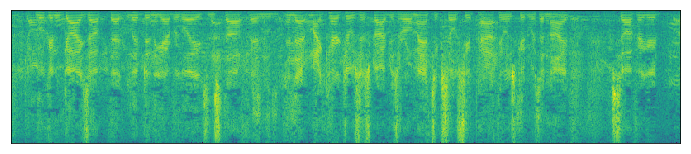

In [5]:

x1 = kaldi_io.read_mat('/home/yangwenhao/local/project/lstm_speaker_verification/data/vox1/klsp/spect/dev/raw_spect_dev.1.ark:26')
x = torch.tensor(x1).reshape(1,1,-1,161).requires_grad_()
print("input shape: ", x.shape)

plt.figure(figsize=(12, 5))

im = plt.imshow(x1.transpose())
plt.xticks([])
plt.yticks([])
# plt.colorbar(im)  # 显示颜色标尺
# print(list(in_feature_grads.keys()))
# print(list(in_feature.keys()))

In [6]:
model.eval()
logits, feat = model(x)
logits[0].max().backward()
# print(feature_grads[0].shape)

In [8]:
x_stdf = x.std(dim=2)
print(x_stdf.shape)
print(x_stdf)

torch.Size([1, 1, 161])
tensor([[[1.3384, 1.4199, 1.7885, 1.7582, 1.6134, 2.1523, 2.1270, 1.8590,
          2.1232, 2.2260, 2.1663, 2.2036, 2.1822, 2.4124, 2.5129, 2.4155,
          2.2969, 2.0309, 1.8676, 1.9240, 1.8905, 1.9797, 1.9647, 2.0358,
          1.9653, 2.0338, 1.9903, 2.0872, 2.0844, 2.0380, 2.0830, 2.0677,
          2.0664, 2.0859, 2.0524, 2.1434, 2.3226, 2.2375, 2.2666, 2.1579,
          2.1348, 2.0430, 1.9685, 2.0557, 1.9932, 2.0255, 2.0400, 2.0381,
          2.1096, 1.9404, 2.0176, 1.9760, 2.0436, 2.1023, 2.1092, 2.0096,
          1.9972, 2.0039, 2.0035, 1.9616, 1.9614, 2.0154, 1.9791, 1.9095,
          1.8978, 1.8130, 1.8758, 1.9157, 1.9231, 1.9581, 2.1079, 2.1538,
          2.1056, 2.1995, 2.2711, 2.3116, 2.1984, 2.1739, 2.2614, 2.1851,
          2.2188, 2.1548, 2.2212, 2.1689, 2.0000, 2.0245, 2.0699, 1.9058,
          1.8566, 2.0730, 2.1696, 2.1919, 2.2501, 2.3989, 2.4188, 2.4699,
          2.6022, 2.6490, 2.6680, 2.6826, 2.7538, 2.8089, 2.9465, 2.7882,
          2.66

In [9]:
print("Num of stored biases layers: ", len(bias_layers))
print("Num of stored gradient of biases layers: ", len(out_feature_grads))

ups = torch.nn.UpsamplingBilinear2d(size=(811, 161))
grad = x.grad# .clamp_min(0)
ingrad = grad.abs()

input_gradient = (x.grad * x)# .clamp_min(0)

# grad cam
grad_cam = torch.zeros_like(x)
L = len(cam_layers)
assert len(out_layer_grad) == L, print(len(out_layer_grad))

# for i,l in enumerate(out_layer_grad):
#     weight = out_layer_grad[i].mean(dim=(2, 3), keepdim=True)
#     weight /= weight.sum()
#     feat = out_layer_feat[L-1-i]

#     T = (feat * weight).sum(dim=1, keepdim=True).clamp_min(0)
#     grad_cam += ups(T)
last_grad = out_layer_grad[0]
last_feat = out_layer_feat[-1]

weight = last_grad.mean(dim=(2, 3), keepdim=True)
weight /= weight.sum()
feat = last_feat# .copy()

T = (feat * weight).sum(dim=1, keepdim=True)# .clamp_min(0)
grad_cam += ups(T).abs()
    

# grad cam ++ last
last_grad = out_layer_grad[0]
last_feat = out_layer_feat[-1]
first_derivative = logits[0].max().exp() * last_grad
alpha = last_grad.pow(2) / (2 * last_grad.pow(2) + (last_grad.pow(3) * last_feat).sum(dim=(2, 3), keepdim=True))
# weight = alpha * (first_derivative.clamp_min_(0))
weight = alpha * (first_derivative.abs())

weight = weight.mean(dim=(2, 3), keepdim=True)
weight /= weight.sum()

grad_cam_pp = (last_feat * weight).sum(dim=1, keepdim=True)
grad_cam_pp = ups(grad_cam_pp)

# grad_cam_pp -= grad_cam_pp.min()
grad_cam_pp = grad_cam_pp.abs()
grad_cam_pp /= grad_cam_pp.max()

# full grad
full_grad = input_gradient.clone()

L = len(bias_layers)
for i,l in enumerate(bias_layers):
    bias = biases[L-i-1]
    if len(bias.shape) == 1:
        bias = bias.reshape(1,-1,1,1)
    bias = bias.expand_as(out_feature_grads[i])
    
#     bias_grad = (out_feature_grads[i]*bias).sum(dim=1, keepdim=True)
    bias_grad = (out_feature_grads[i]*bias).mean(dim=1, keepdim=True)
#     bias_grad = (out_feature_grads[i]*bias).clamp_min(0).mean(dim=1, keepdim=True)
#     bias_grad /= bias_grad.max()
    full_grad += ups(bias_grad)
    
# full_grad -= full_grad.min()

full_grad = full_grad.abs()
full_grad /= full_grad.max()

vis_grad = [x, ingrad, ingrad*x_stdf, grad_cam, grad_cam_pp, full_grad]

Num of stored biases layers:  10
Num of stored gradient of biases layers:  10


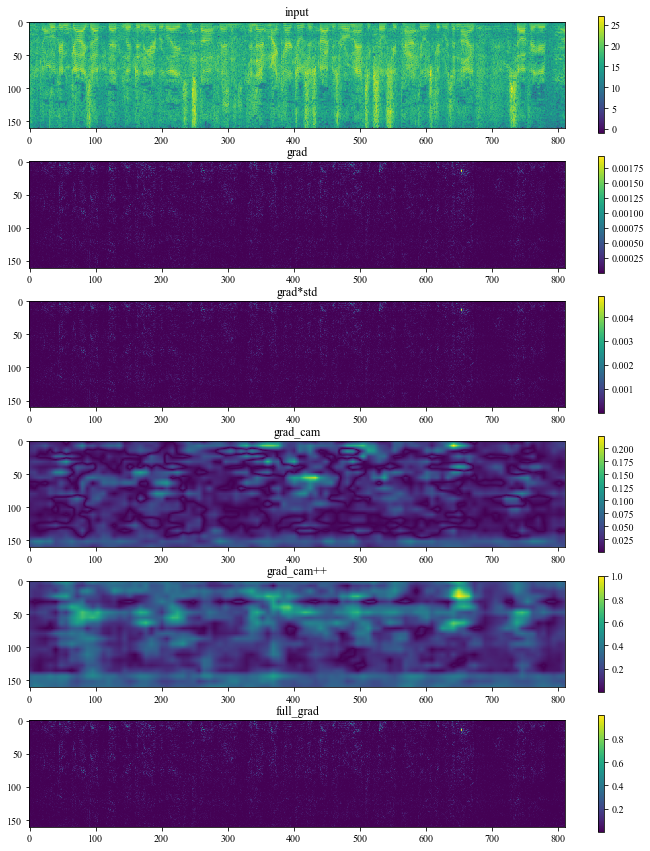

In [10]:
plt.figure(figsize=(12, 15))
# norm = matplotlib.colors.Normalize(vmin=-10., vmax=10.)
names = ['input', 'grad', 'grad*std', 'grad_cam', 'grad_cam++', 'full_grad']
for i in range(len(vis_grad)):
    ax = plt.subplot(len(vis_grad), 1, i+1)
    ax.set_title(names[i])
    im = ax.imshow(vis_grad[i].squeeze().detach().numpy().transpose()) #, norm=norm)
    plt.colorbar(im)  # 显示颜色标尺


(811, 161)
(537, 161)
(811, 161)
(636, 161)


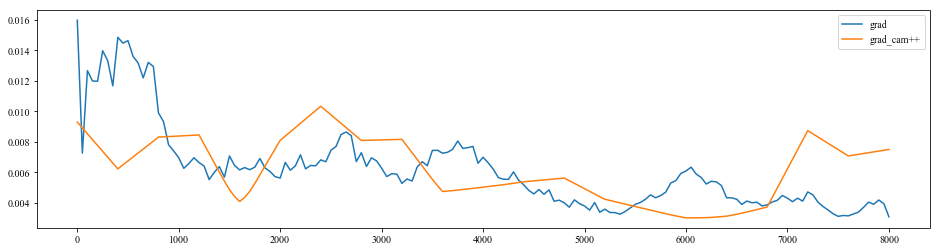

In [11]:
plt.figure(figsize=(16, 4))
names_np = np.array(names)
indexs = np.array([1, 4])
# for i in [1,2, 3]:
for i in indexs:

    grad_plus = vis_grad[i].squeeze().detach().numpy()# .transpose()
    grad_plus_time = grad_plus.mean(axis=1)
    grad_plus_time_mean = grad_plus_time.mean()*0.8
    print(grad_plus.shape)

    freq_grad = grad_plus[np.where(grad_plus_time>grad_plus_time_mean)[0]]
    print(freq_grad.shape)

    freq_grad = freq_grad.mean(axis=0)

    # .mean(axis=0)
    # print(freq_grad.shape)
    x = np.arange(161)*8000/160
    plt.plot(x, freq_grad/freq_grad.sum())

#     grad_plus_mean = grad_plus.mean(axis=0)
#     plt.plot(grad_plus_mean/grad_plus_mean.sum())
    
plt.legend(names_np[indexs])


0.5832305795314426
0.5807644882860666
0.6325524044389642
0.6387176325524044
0.5684340320591862


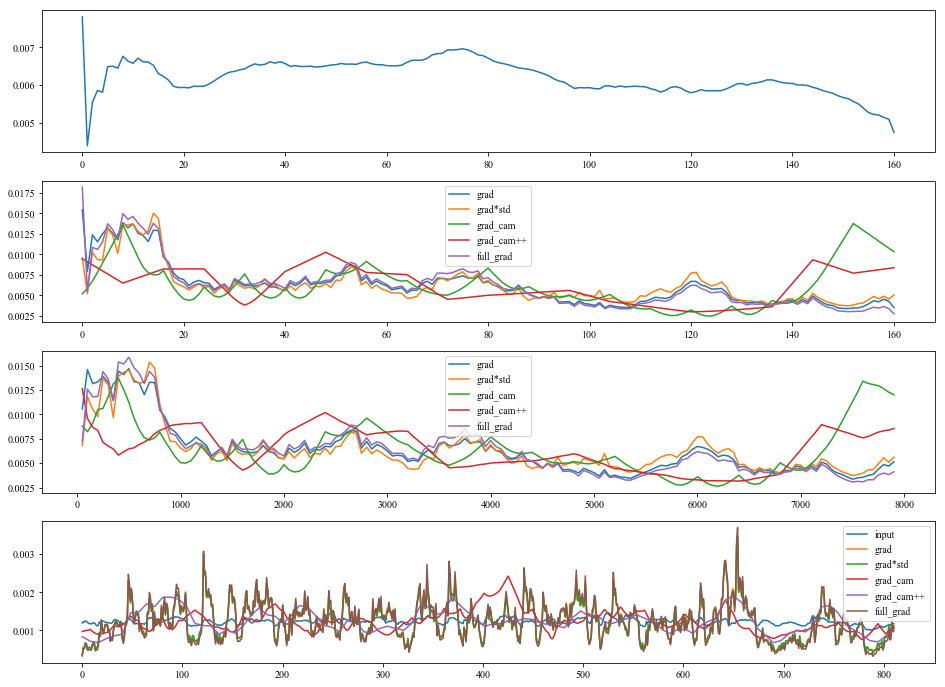

In [12]:
input_norm = vis_grad[0].squeeze().detach().numpy().mean(axis=0)[1:-2]
input_norm /= input_norm.sum()
def plot_grad(grad, axis):
    this_grad = grad.squeeze().detach().numpy().transpose().mean(axis=axis)
    this_grad /= this_grad.sum()
    plt.plot(this_grad)
    
def plot_part_grad(grad, axis):
    this_grad = grad.squeeze().detach().numpy()# .transpose()
    all_time = len(this_grad)
    grad_plus_time = this_grad.mean(axis=1)
    grad_plus_time_mean = grad_plus_time.mean()*0.9
    freq_grad = this_grad[np.where(grad_plus_time>grad_plus_time_mean)[0]]
    part_time = len(freq_grad)
    this_grad = freq_grad.mean(axis=0)[1:-2]
    print(part_time/all_time)
    this_grad /= input_norm
    this_grad /= this_grad.sum()
    x = np.arange(161)*8000/160
    plt.plot(x[1:-2], this_grad)

    


plt.figure(figsize=(16, 12))

plt.subplot(4,1,1)
plot_grad(vis_grad[0], 1)
    
plt.subplot(4,1,2)
for i in range(1, len(vis_grad)):
    plot_grad(vis_grad[i], 1)

plt.legend(['grad', 'grad*std', 'grad_cam', 'grad_cam++', 'full_grad'])

plt.subplot(4,1,3)
for i in range(1, len(vis_grad)):
    plot_part_grad(vis_grad[i], 1)

plt.legend(['grad', 'grad*std', 'grad_cam', 'grad_cam++', 'full_grad'])


# plt.subplot(5,1,4)
# plot_grad(vis_grad[0], 0)
    
plt.subplot(4,1,4)
for i in range(len(vis_grad)):
    plot_grad(vis_grad[i], 0)

plt.legend(['input', 'grad', 'grad*std', 'grad_cam', 'grad_cam++', 'full_grad'])


In [38]:
from Process_Data.audio_processing import Make_Spect

music_s0 = ['/home/storage/yangwenhao/dataset/musan/music/fma/music-fma-0000.wav',
            '/home/storage/yangwenhao/dataset/musan/music/fma/music-fma-0001.wav',
            '/home/storage/yangwenhao/dataset/musan/music/fma/music-fma-0002.wav',
           '/home/storage/yangwenhao/dataset/musan/speech/librivox/speech-librivox-0000.wav',
           '/home/storage/yangwenhao/dataset/musan/speech/librivox/speech-librivox-0001.wav',
           '/home/storage/yangwenhao/dataset/musan/speech/librivox/speech-librivox-0002.wav',
           '/home/storage/yangwenhao/dataset/musan/noise/free-sound/noise-free-sound-0000.wav',
           '/home/storage/yangwenhao/dataset/musan/noise/free-sound/noise-free-sound-0001.wav',
           '/home/storage/yangwenhao/dataset/musan/noise/free-sound/noise-free-sound-0002.wav']
sps =[]
for m in music_s0:
    sp_s0 = Make_Spect(m, windowsize=0.025, stride=0.01, window=np.hamming,
               bandpass=False, lowfreq=0, highfreq=0, log_scale=True,
               preemph=0.97, duration=False, nfft=512, normalize=False)
    sps.append(sp_s0)

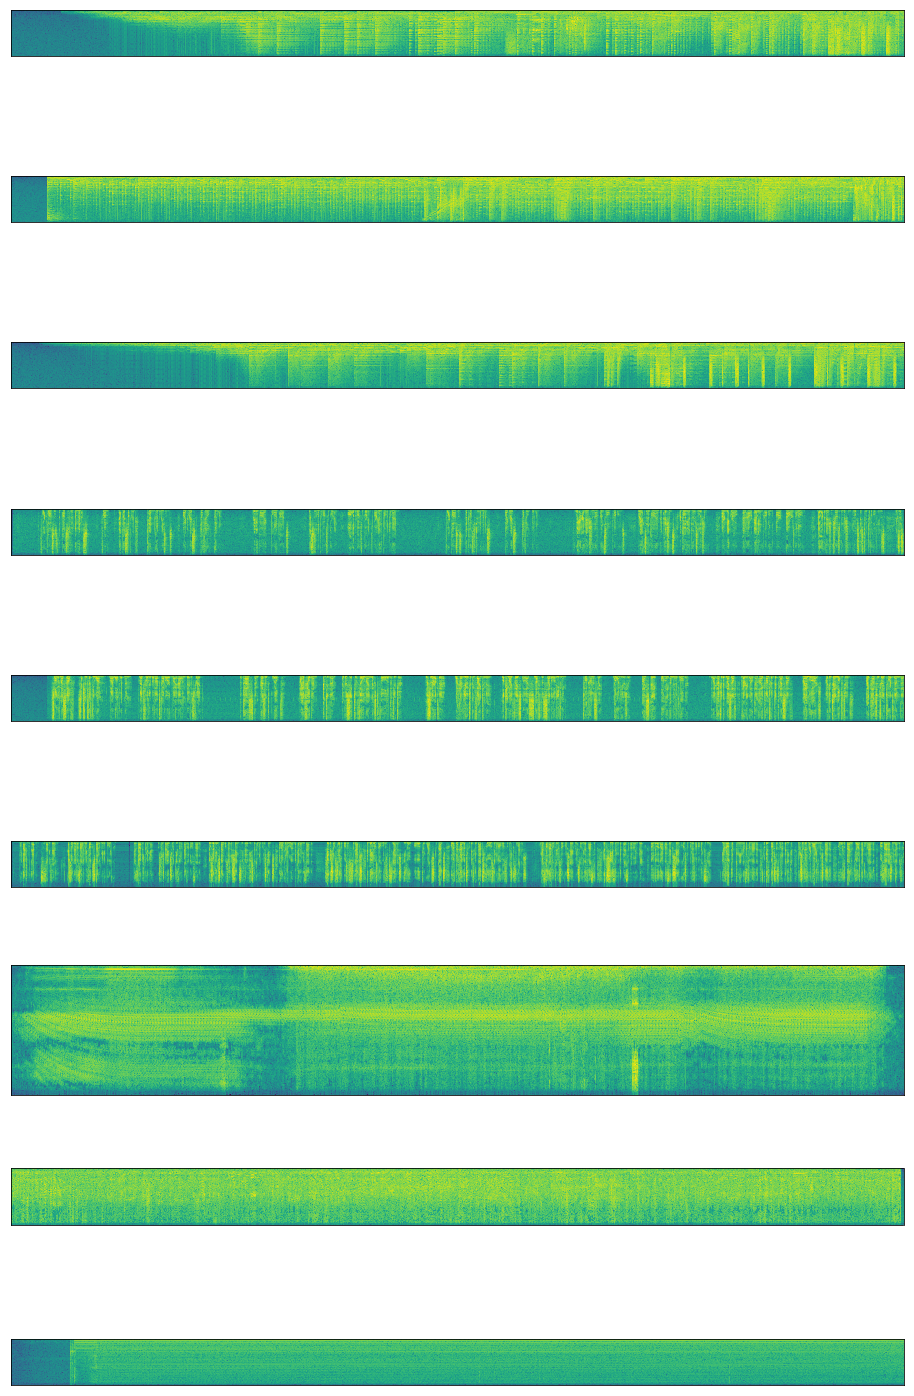

In [40]:
plt.figure(figsize=(16, int(3*len(music_s0))))


for i,x in enumerate(sps):
    plt.subplot(len(sps),1,i+1)
    show_sp = x[:5000, :]
    im = plt.imshow(show_sp.transpose())
    plt.xticks([])
    plt.yticks([])

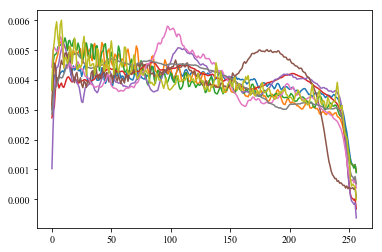

In [41]:
for s in sps:
    sp_s0_f = s.mean(axis=0)
    sp_s0_f /= sp_s0_f.sum()
    plt.plot(sp_s0_f)

In [15]:
upsample = torch.nn.UpsamplingBilinear2d(size=(468, 161))
input_graident = upsample(input_graident)
bias_gradient = upsample(bias_gradient)

saliency_map = input_graident + bias_gradient

print(saliency_map.shape)

torch.Size([1, 1, 468, 161])


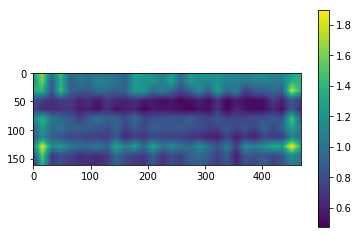

In [16]:
im = plt.imshow(saliency_map.squeeze().detach().numpy().transpose())
plt.colorbar(im)  # 显示颜色标尺


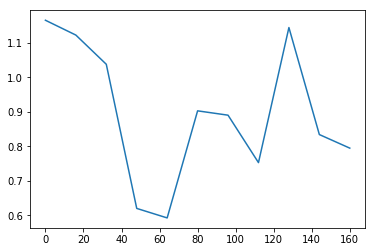

In [17]:
plt.plot(saliency_map.squeeze().detach().numpy().transpose().mean(axis=1))

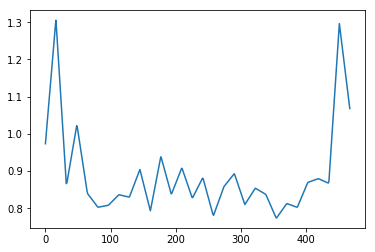

In [18]:
plt.plot(saliency_map.squeeze().detach().numpy().transpose().mean(axis=0))